# Flower Recognition
This is a flower classfication model for 16 categories of flowers. 
### Load the data
The data used for training the model is from Kaggle (https://www.kaggle.com/datasets/l3llff/flowers). It contains 16 different categories of flowers.

In [9]:
from google.colab import drive
import os

mount='/gdrive'
drive.mount(mount)
working_dir = mount + "/My Drive/Projects/Flower_Recognition"
%cd $working_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Projects/Flower_Recognition


In [10]:
import numpy as np
import pandas as pd
import os
from sklearn.datasets import load_files

In [11]:
from tensorflow.keras.utils import img_to_array, load_img
from tqdm import tqdm
from os.path import exists

def img_to_arr(path_list):
    arr = []
    # size = 128, 128
    img_width, img_height = 128, 128
    for path in tqdm(path_list):
        img = load_img(path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
    return arr

if exists('X_data.npy') and exists('y_data.npy') and exists('classes.npy'):
    X = np.load('X_data.npy')
    y = np.load('y_data.npy')
    classes = np.load('classes.npy')
else:
    data_dir =  r'./flowers'
    data = load_files(data_dir)

    X = np.array(data['filenames'])
    y = np.array(data['target'])
    labels = np.array(data['target_names'])

    X = np.array(img_to_arr(X))
    classes = np.array(os.listdir("./flowers"))
    with open('X_data.npy', 'wb') as f:
        np.save(f, X)
    with open('y_data.npy', 'wb') as f:
        np.save(f, y)
    with open('classes.npy', 'wb') as f:
        np.save(f, classes)

print(X.shape)
print(classes)

(15740, 128, 128, 3)
['astilbe' 'bellflower' 'black_eyed_susan' 'calendula' 'california_poppy'
 'carnation' 'common_daisy' 'coreopsis' 'daffodil' 'dandelion' 'iris'
 'magnolia' 'rose' 'sunflower' 'tulip' 'water_lily']


There are 15740 total images, and each image used for trainingg is of size 128*128 with 3 channels. 
### Visualize images

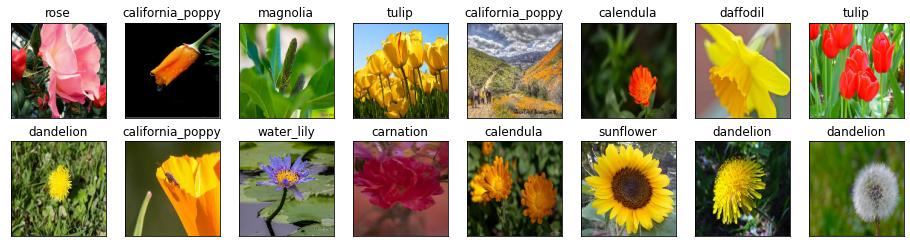

In [12]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (16,4))
l = len(classes)
for i in range(l):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(classes[y[i]])

### Preprocess the data
The value of each RGB channel of each pixel needs to be between 0 and 1. By dividing 255, the value range changes from \[0,255\] to \[0,1\].

In [13]:
from keras.utils import np_utils

X = X.astype('float32') / 255
y = np.array(np_utils.to_categorical(y,l))

### Split the data
I choose the ratio of training, test and validation set to be 8:1:1. 

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('Test data number: ', X_test.shape[0])
print('Valid data number: ', X_valid.shape[0])
print('Train data number: ', X_train.shape[0])

Test data number:  1574
Valid data number:  1574
Train data number:  12592


### Define the model
For the data training, I use a ResNet34 model.

In [25]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, AveragePooling2D, \
Dense, Flatten, Dropout, BatchNormalization, Activation, Add, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

l = 16
def identity_block(x, filter):
    x_skip = x
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization(axis=3)(x)

    x = Add()([x, x_skip])     
    x = Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    x_skip = x
    x = Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization(axis=3)(x)
    x_skip = Conv2D(filter, (1,1), strides = (2,2))(x_skip)

    x = Add()([x, x_skip])     
    x = Activation('relu')(x)
    return x

def ResNet34(shape = (128, 128, 3), classes = 16):
    x_input = Input(shape)
    x = ZeroPadding2D((3, 3))(x_input)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    block_layers = [3, 4, 6, 3]
    filter_size = 64

    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)

    x = AveragePooling2D((2,2), padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    model = Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

model = ResNet34()

Here is the summary:

In [26]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 67, 67, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 67, 67, 64)  256         ['conv2d[0][0]']          

### Define the optimizer
I use Nadam optimizer with learning rate 0.01.

In [10]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model

In [11]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 100
batch_size=32
 
train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)
 
test_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow(
    X_train,y_train,
    batch_size=batch_size)
 
validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)
 
checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/PId_Best.h5", save_best_only = True, verbose = 1)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)
 
history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data = validation_generator,
                            verbose=1,
                            steps_per_epoch=len(X_train) // batch_size,
                            callbacks=[checkpointer, learning_rate_reduction])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
393/393 [==============================] - ETA: 0s - loss: 2.6686 - accuracy: 0.1561
Epoch 1: val_loss improved from inf to 2.06966, saving model to /gdrive/My Drive/PId_Best.h5
393/393 [==============================] - 93s 180ms/step - loss: 2.6686 - accuracy: 0.1561 - val_loss: 2.0697 - val_accuracy: 0.2618 - lr: 0.0010
Epoch 2/100
393/393 [==============================] - ETA: 0s - loss: 2.1208 - accuracy: 0.2609
Epoch 2: val_loss improved from 2.06966 to 1.99246, saving model to /gdrive/My Drive/PId_Best.h5
393/393 [==============================] - 70s 177ms/step - loss: 2.1208 - accuracy: 0.2609 - val_loss: 1.9925 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 3/100
393/393 [==============================] - ETA: 0s - loss: 1.9222 - accuracy: 0.3456
Epoch 3: val_loss did not improve from 1.99246
393/393 [==============================] - 67s 170ms/step - loss: 1.9222 - accuracy: 0.3456 - val_loss: 2.2219 - val_accuracy: 0.2865 - lr: 0.0010
Epoch 4/100
393/393 [==========

The validation accuracy is 0.88 at the end.

### Visualize the training process

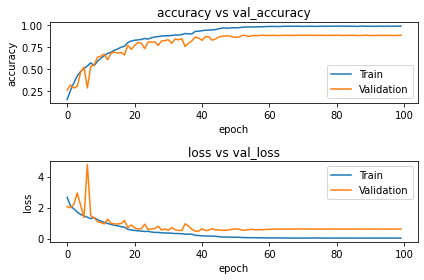

In [13]:
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1)
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
plot(history)

In [24]:
# import tensorflow as tf
# model.save('saved_model')
# model = tf.keras.models.load_model('saved_model')
# model.summary()

### Test the model

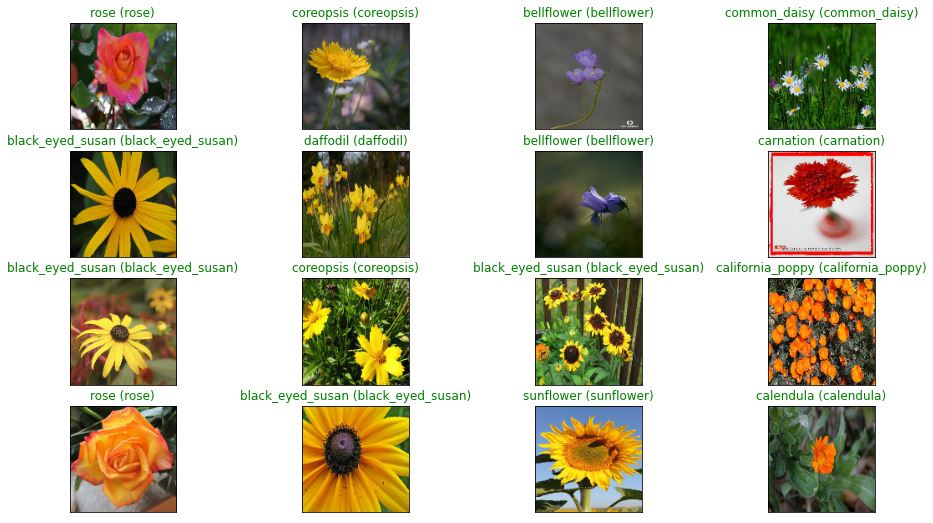

In [21]:
def visualize(y_pred):
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(classes[pred_idx], classes[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize(model.predict(X_test))

These are some pictures from the test set. Red indicates misclassification. \
The confusion matrix is as below:

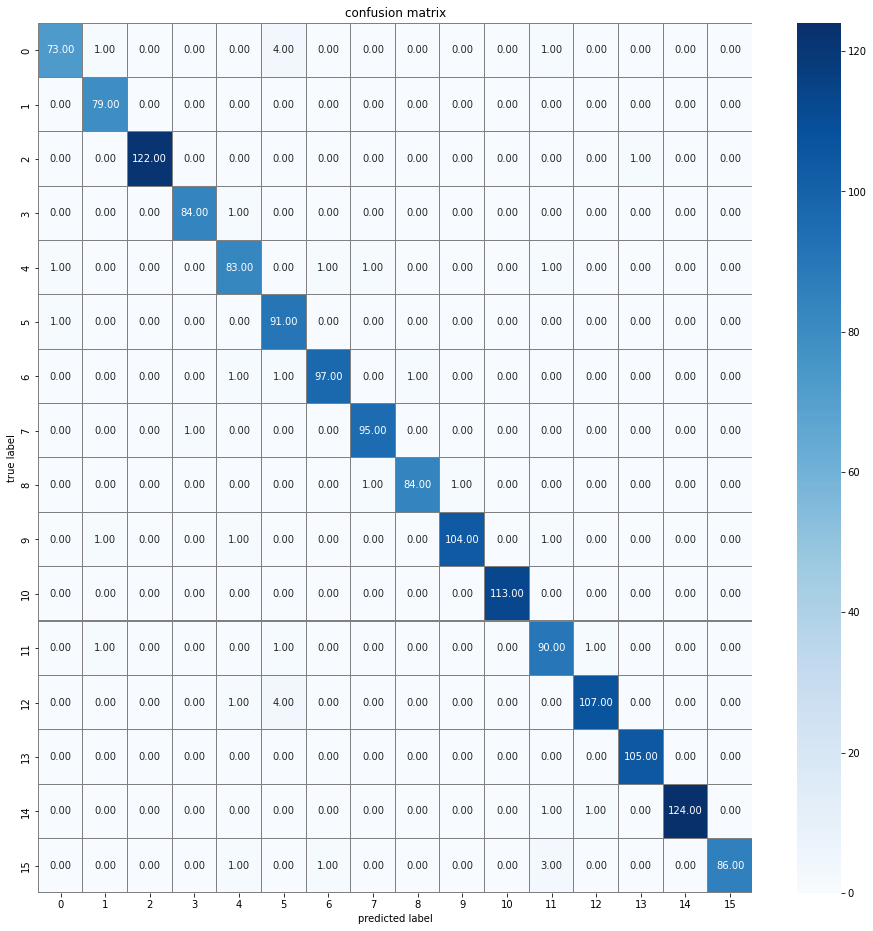

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (16,16))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Blues",
            linecolor = "gray",fmt = ".2f",ax=ax)

plt.xlabel("predicted label")
plt.ylabel("true label")
plt.title("confusion matrix")
plt.show()

The classification model performs well on all categories of flowers.